Imports

In [73]:
import os
import zipfile
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import warnings
from kaggle.api.kaggle_api_extended import KaggleApi
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import RocCurveDisplay, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from skopt import BayesSearchCV

Laden des Datensatzes

In [74]:
# initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# check if the dataset is available
if not os.path.exists('kaggle/import/Billionaires Statistics Dataset.csv'):
    
    # search the dataset
    datasets = api.dataset_list(search="Billionaires Statistics Dataset (2023)")

    # pick the dataset
    dataset = datasets[0]

    api.dataset_download_files(dataset.ref, path='kaggle/import')

    # unpack the zip file
    with zipfile.ZipFile('kaggle/import/billionaires-statistics-dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('kaggle/import')

    # delete the zip file
    os.remove('kaggle/import/billionaires-statistics-dataset.zip')

Datensichtung

In [75]:
# Datenset einlesen
df = pd.read_csv('kaggle/import/Billionaires Statistics Dataset.csv')
print("There are {:,} rows and {} columns in the dataset".format(df.shape[0], df.shape[1]))
print(df.head().T)

# summary table function
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    num_cols = df.select_dtypes(include=['float64','int64'])
    summ = pd.DataFrame(num_cols.dtypes, columns=['data type'])
    summ['#missing'] = num_cols.isnull().sum().values 
    summ['%missing'] = num_cols.isnull().sum().values / len(df) * 100
    summ['#nunique'] = num_cols.nunique().values
    desc = pd.DataFrame(num_cols.describe(include='number').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = num_cols.loc[0].values
    summ['second value'] = num_cols.loc[1].values
    summ['third value'] = num_cols.loc[2].values
    
    return summ 

summary(df)

There are 2,640 rows and 35 columns in the dataset
                                                                           0  \
rank                                                                       1   
finalWorth                                                            211000   
category                                                    Fashion & Retail   
personName                                          Bernard Arnault & family   
age                                                                    74.00   
country                                                               France   
city                                                                   Paris   
source                                                                  LVMH   
industries                                                  Fashion & Retail   
countryOfCitizenship                                                  France   
organization                                LVMH Moët Hennessy Louis 

,data type,#missing,%missing,#nunique,min,max,average,standard_deviation,first value,second value,third value
rank,int64,0,0.00,219,1.00,"2,540.00","1,289.16",739.69,1.00,2.00,3.00
finalWorth,int64,0,0.00,219,"1,000.00","211,000.00","4,623.79","9,834.24","211,000.00","180,000.00","114,000.00"
age,float64,65,2.46,79,18.00,101.00,65.14,13.26,74.00,51.00,59.00
birthYear,float64,76,2.88,77,"1,921.00","2,004.00","1,957.18",13.28,"1,949.00","1,971.00","1,964.00"
birthMonth,float64,76,2.88,12,1.00,12.00,5.74,3.71,3.00,6.00,1.00
birthDay,float64,76,2.88,31,1.00,31.00,12.10,9.92,5.00,28.00,12.00
cpi_country,float64,184,6.97,63,99.55,288.57,127.76,26.45,110.05,117.24,117.24
cpi_change_country,float64,184,6.97,44,-1.90,53.50,4.36,3.62,1.10,7.50,7.50
gross_tertiary_education_enrollment,float64,182,6.89,63,4.00,136.60,67.23,21.34,65.60,88.20,88.20
gross_primary_education_enrollment_country,float64,181,6.86,60,84.70,142.10,102.86,4.71,102.50,101.80,101.80


The column "birthDate" is currently stored as an object, so I will convert it to a datetime data type to allow better handling of birth dates. The "date" column only has two different values, so I've decided to remove it as it doesn't provide any useful information. Regarding the column "gdp_country", it should be noted that it currently has the object data type as the values start with the symbol "$". Therefore, I will convert it to the float data type in order to display the economic data correctly.

In [76]:
cat=df[['selfMade','gender','status','country']]
for i in cat:
    obs=df[i].value_counts()
    avg_claim=df.groupby(i)["selfMade"].mean()
    display(pd.DataFrame({"Number of Policyholders":obs})\
            .sort_values('Number of Policyholders', ascending=False)\
            .style.set_caption("Variable: {}".format(i)))

,Number of Policyholders
selfMade,
True,1812
False,828


,Number of Policyholders
gender,
M,2303
F,337


,Number of Policyholders
status,
D,1223
U,855
E,268
N,150
Split Family Fortune,79
R,65


,Number of Policyholders
country,
United States,754
China,523
India,157
Germany,102
United Kingdom,82
Russia,79
Switzerland,78
Hong Kong,68
Italy,55


Plot 1

In [77]:
# convert from 'True'/'False' to 1/0
df['selfMade'] = df['selfMade'].map({True: 1, False: 0})

In [78]:
# drop columns
df.drop(columns=['date','personName','city','source','industries','countryOfCitizenship','organization','lastName',
                 'firstName', 'title','residenceStateRegion'],inplace=True)

In [79]:
# print missing values
print("There are {} missing values in the data.".format(df.isna().sum().sum()))

There are 4228 missing values in the data.


In [80]:
# using method ffill to get rid of missing values
for column in df:
    df[column]=df[column].fillna(method='ffill')

print("There are {} missing values in the data.".format(df.isna().sum().sum()))

There are 1 missing values in the data.


In [81]:
# using method mode to fill the last missing value
for column in df:
    mode_value = df[column].mode()[0]    
    df[column]=df[column].fillna(mode_value)

print("There are {} missing values in the data.".format(df.isna().sum().sum()))

There are 0 missing values in the data.


In [82]:
# check for duplicates
print("There are {} duplicate values in the data.".format(df.duplicated().sum()))

There are 3 duplicate values in the data.


In [83]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [84]:
# convert variables to integer
df['birthYear']=df['birthYear'].astype(int)
df['birthMonth']=df['birthMonth'].astype(int)
df['birthDay']=df['birthDay'].astype(int)

# convert `birthDate` column to Datetimeindex
df['birthDate']=pd.to_datetime(df['birthDate'])

In [85]:
# convert variable to float
df['gdp_country'] = df['gdp_country'].str.replace('$','').replace(',','', regex=True).astype(float)

In [86]:
num_outlier=[]
num_cols = df.select_dtypes(include=['float64','int64'])
print("There are {:,} observations in the data before delete the outliers.".format(df.shape[0]))

for column in num_cols.columns:
    # Calculate the z-score for each student's height
    z = np.abs(stats.zscore(df[column]))

    # Identify outliers as students with a z-score greater than 3
    threshold = 3
    outliers = df[z > threshold]
    num_outlier.append(len(outliers))
    # drop rows containing outliers
    df.drop(outliers.index,inplace=True)    
    
print("There are {:,} observations in the data after delete the outliers.".format(df.shape[0]))    
df_outlier=pd.DataFrame({"column":num_cols.columns,"number_of_outliers":num_outlier})
df_outlier

There are 2,637 observations in the data before delete the outliers.
There are 2,395 observations in the data after delete the outliers.


,column,number_of_outliers
0,rank,0
1,finalWorth,37
2,age,6
3,selfMade,0
4,birthYear,0
5,birthMonth,0
6,birthDay,0
7,cpi_country,46
8,cpi_change_country,0
9,gdp_country,0


In [87]:
# plot 1 - number of Billionaired categorized by selfMade
top_selfmade = df['selfMade'].value_counts()
fig1 = px.bar(top_selfmade, x=top_selfmade.index, y=top_selfmade.values,
              title="Number of Billionaires categorized by Self Made",
              color_discrete_sequence=px.colors.qualitative.Set3)
fig1.update_xaxes(title="Self Made (0 for False, 1 for True)")
fig1.update_yaxes(title="Number of Billionaires")
fig1.show()

In [88]:
# top 10 countries with the most people categorized by selfMade
top_selfmade_countries = df[df['selfMade'] == 1]['country'].value_counts().head(10)

# plot 2 - bar plot of the top 10 countries with most billionaires categorized as selfMade
fig2 = px.bar(top_selfmade_countries, x=top_selfmade_countries.index, y=top_selfmade_countries.values,
              title="Top 10 Countries with Most Self Made Billionaires",
              color_discrete_sequence=px.colors.qualitative.Set3)
fig2.update_xaxes(title="Country")
fig2.update_yaxes(title="Number of Self Made Billionaires")
fig2.show()

Plot 3

In [89]:
# plot 3 - rank vs selfMade by gender
fig3 = px.scatter(df, x="rank", y="selfMade", color="gender", title="Billionaires' Rank vs. Self Made Status by Gender")
fig3.update_xaxes(type='log', title="Rank (log scale)")
fig3.update_yaxes(title="Self Made (0 for False, 1 for True)")
fig3.show()

In [90]:
# plot 4 - age distribution of billionaires by gender
fig4 = px.box(df, x="gender", y="age", title="Age Distribution of Billionaires by Gender",
              color_discrete_sequence=['blue', 'red'])
fig4.update_xaxes(title="Gender")
fig4.update_yaxes(title="Age")
fig4.show()

In [91]:
# describe the dataset
df.describe().T

,count,mean,min,25%,50%,75%,max,std
rank,"2,395.00","1,298.97",38.00,659.00,"1,312.00","1,905.00","2,540.00",729.71
finalWorth,"2,395.00","3,730.94","1,000.00","1,500.00","2,300.00","4,200.00","33,400.00","4,132.17"
age,"2,395.00",65.02,26.00,56.00,65.00,74.00,101.00,12.98
selfMade,"2,395.00",0.70,0.00,0.00,1.00,1.00,1.00,0.46
birthDate,2395,1957-09-25 18:48:45.093945664,1921-09-11 00:00:00,1948-06-30 00:00:00,1958-01-01 00:00:00,1966-10-23 12:00:00,1996-07-23 00:00:00,NaN
birthYear,"2,395.00","1,957.31","1,921.00","1,948.00","1,958.00","1,966.00","1,996.00",12.99
birthMonth,"2,395.00",5.70,1.00,2.00,6.00,9.00,12.00,3.71
birthDay,"2,395.00",11.92,1.00,1.00,10.00,21.00,31.00,9.90
cpi_country,"2,395.00",125.19,99.55,117.24,117.24,125.08,182.75,20.72
cpi_change_country,"2,395.00",4.22,-1.90,1.70,2.90,7.50,7.70,2.84


In [92]:
# feature engineering - correlation with target selfMade
import matplotlib
corr=df.select_dtypes(include=['float64','int64','bool']).corr()
corr=corr['selfMade'].sort_values(ascending=True)[1:-1]
fig = go.Figure()

pal=sns.color_palette("Reds_r",8).as_hex()
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig.add_trace(go.Bar(x=corr[corr<0], y=corr[corr<0].index, 
                     marker_color=rgb, orientation='h', 
                     marker_line=dict(color=pal,width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))

pal=sns.color_palette("Blues",8).as_hex()
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig.add_trace(go.Bar(x=corr[corr>=0], y=corr[corr>=0].index, 
                     marker_color=rgb, orientation='h', 
                     marker_line=dict(color=pal,width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))


temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
fig.update_layout(template=temp,title="Feature Correlations with Target",
                  xaxis_title="Correlation", margin=dict(l=250),
                  height=900, width=700, hovermode='closest')
fig.update_xaxes(range=(0.3,-0.2))
fig.show()

In [93]:
# drop columns with low correlation
df.drop(columns=['category','country','state','birthDate','birthDay','birthMonth','birthYear'],inplace=True)

In [94]:
# generating new categorical variable rank, by cutting rank into intervalls
df['rank']=pd.cut(df['rank'],[0,500,1000,1500,2000,2600],labels=[1,2,3,4,5])


In [95]:
# transform the data
y=df.selfMade
X=df.drop('selfMade', axis=1)
X=pd.get_dummies(X, columns=['status','gender'], drop_first=True)
# create new features
pf = PolynomialFeatures(interaction_only=True, include_bias=False)
X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names_out(X.columns))
print("New data shape with interaction terms:",X_pf.shape)
X_pf.head()

New data shape with interaction terms: (2395, 210)


,rank,finalWorth,age,cpi_country,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,...,status_N status_R,status_N status_Split Family Fortune,status_N status_U,status_N gender_M,status_R status_Split Family Fortune,status_R status_U,status_R gender_M,status_Split Family Fortune status_U,status_Split Family Fortune gender_M,status_U gender_M
0,1.00,"33,400.00",54.00,125.08,2.90,"19,910,000,000,000.00",50.60,100.20,77.00,9.40,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,"32,600.00",74.00,105.48,0.50,"5,081,769,542,380.00",63.20,98.80,84.20,11.90,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,1.00,"32,100.00",65.00,119.62,1.70,"2,827,113,184,696.00",60.00,101.20,81.30,25.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1.00,"31,600.00",74.00,117.24,7.50,"21,427,700,000,000.00",88.20,101.80,78.50,9.60,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4,1.00,"31,600.00",72.00,117.24,7.50,"21,427,700,000,000.00",88.20,101.80,78.50,9.60,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [96]:
# removing both constant and quasi-constant
var_thr = VarianceThreshold(threshold = 0.25)
var_thr.fit(X_pf)

var_thr.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [97]:
# pick up the low variance columns
concol = [column for column in X_pf.columns 
          if column not in X_pf.columns[var_thr.get_support()]]

for features in concol:
    print(features)

status_E
status_N
status_R
status_Split Family Fortune
status_U
gender_M
status_E status_N
status_E status_R
status_E status_Split Family Fortune
status_E status_U
status_E gender_M
status_N status_R
status_N status_Split Family Fortune
status_N status_U
status_N gender_M
status_R status_Split Family Fortune
status_R status_U
status_R gender_M
status_Split Family Fortune status_U
status_Split Family Fortune gender_M
status_U gender_M


In [98]:
# drop low variance collumns
X_pf.drop(concol,axis=1,inplace=True)
print("New data shape with interaction terms:",X_pf.shape)

New data shape with interaction terms: (2395, 189)


In [99]:
# scale the features
scaler=StandardScaler()
X_pf=pd.DataFrame(scaler.fit_transform(X_pf), columns=X_pf.columns)

In [100]:
# create the training sets
X_train, X2, y_train, y2 = train_test_split(X_pf, y, train_size=0.7, shuffle=True, 
                                            stratify=y, random_state=55)

# create the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X2, y2, test_size=0.5, shuffle=True,
                                                stratify=y2, random_state=55)

print("Train Shape:",X_train.shape)
print("Validation Shape:",X_val.shape)
print("Test Shape:",X_test.shape)

Train Shape: (1676, 189)
Validation Shape: (359, 189)
Test Shape: (360, 189)


In [101]:
# initialize the random forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# train the classifier
rf_classifier.fit(X_train, y_train)

# make predictions for the validation set
y_val_pred = rf_classifier.predict(X_val)

# calculate the accuracy on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f'Accuracy on validation set: {accuracy_val:.4f}')

# make predictions for the test set
y_test_pred = rf_classifier.predict(X_test)

# calculate the accuracy on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy on test set: {accuracy_test:.4f}')

# print the classification report
classification_rep = classification_report(y_test, y_test_pred, target_names = ["Not Selfmade", "Selfmade"])
print(classification_rep)


Accuracy on validation set: 0.7437
Accuracy on test set: 0.7417
              precision    recall  f1-score   support

Not Selfmade       0.57      0.50      0.54       107
    Selfmade       0.80      0.84      0.82       253

    accuracy                           0.74       360
   macro avg       0.69      0.67      0.68       360
weighted avg       0.73      0.74      0.74       360



In [102]:
from sklearn.dummy import DummyClassifier

# generate the dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

# train the dummy classifier
dummy_clf.fit(X_train, y_train)

# make predictions on the validation set
y_val_pred_dummy = dummy_clf.predict(X_val)

# get f1-score
f1_val_dummy = f1_score(y_val, y_val_pred_dummy)

# print the f1 score 
print('F1-score des Dummy-Classifiers auf den Validierungsdaten:', f1_val_dummy)


F1-score des Dummy-Classifiers auf den Validierungsdaten: 0.826797385620915


Best parameters found by Bagging with SMOTE:
OrderedDict([('class_weight', 'balanced'), ('criterion', 'entropy'), ('max_depth', 10), ('min_samples_leaf', 1), ('min_samples_split', 4), ('n_estimators', 200)])
F1-score on the validation set: 0.8876811594202898
F1-score on the test set with adjusted threshold: 0.8670967741935484
              precision    recall  f1-score   support

Not Selfmade       0.75      0.68      0.71       113
    Selfmade       0.87      0.90      0.89       271

    accuracy                           0.84       384
   macro avg       0.81      0.79      0.80       384
weighted avg       0.84      0.84      0.84       384



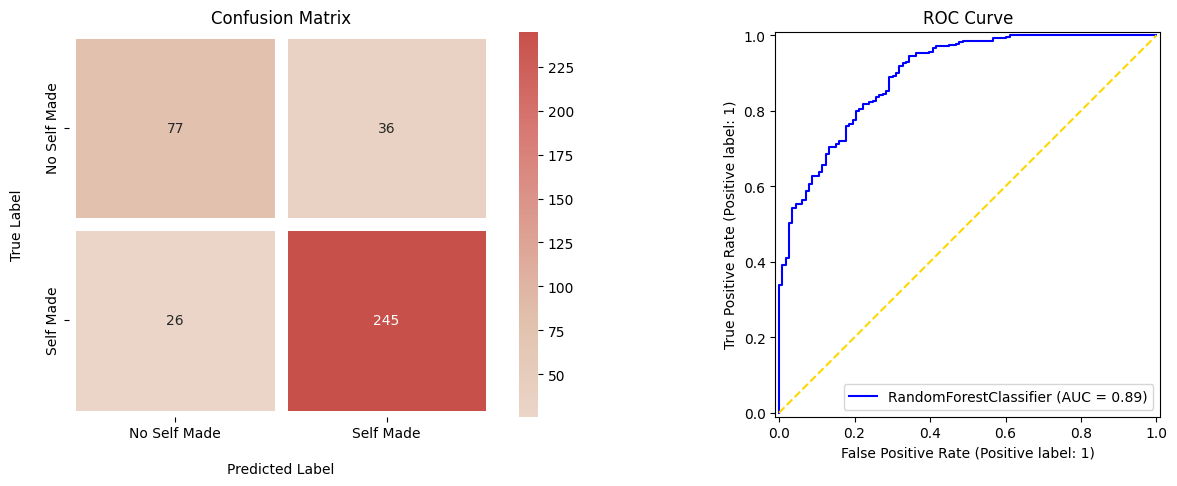

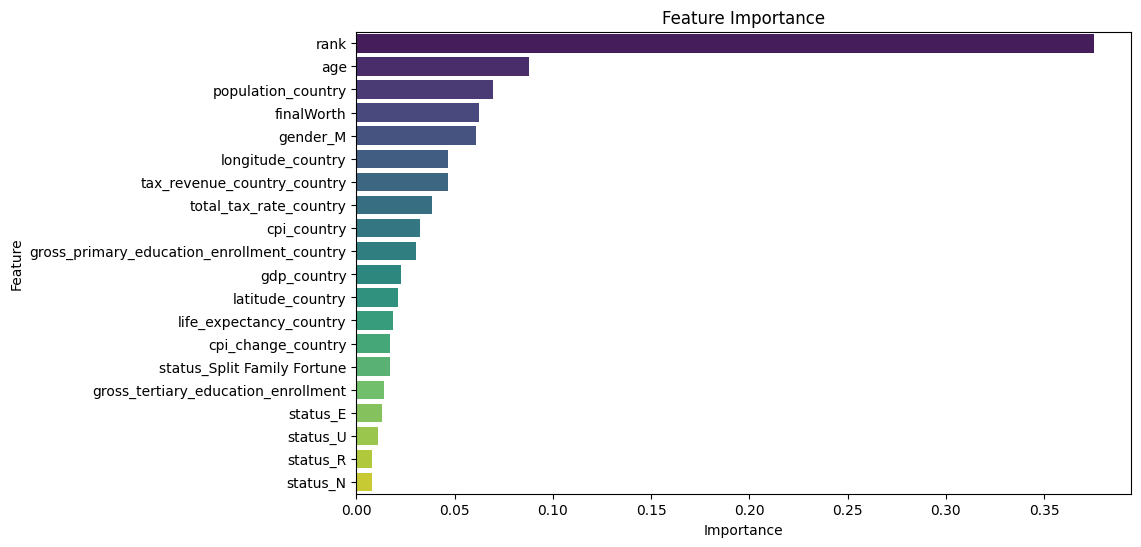

In [103]:


# ignore all warnings
warnings.filterwarnings('ignore')

'''# Entfernen der angegebenen Features
features_to_remove = ['gross_tertiary_education_enrollment', 'status_E', 'status_U', 'status_R', 'status_N']
X = X.drop(columns=features_to_remove)'''

# split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# define the parameter search space for RandomForestClassifier
param_space = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

# set the random seed for reproducibility
random_state = 25
np.random.seed(random_state)

# create the RandomForestClassifier model with balanced class weights
base_estimator = RandomForestClassifier(random_state=random_state, class_weight='balanced')

# apply SMOTE to the training data
smote = SMOTE(random_state=random_state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_val, y_train_val)

# perform bayesian optimization on the resampled data
bayes_search = BayesSearchCV(
    estimator=base_estimator,
    search_spaces=param_space,
    scoring='f1',
    cv=3,
    n_iter=50,
    random_state=random_state
)
bayes_search.fit(X_train_resampled, y_train_resampled)

# retrieve the best model and best parameters
best_model = bayes_search.best_estimator_
best_params = bayes_search.best_params_

# retrain the best model on the entire resampled training set
best_model.fit(X_train_resampled, y_train_resampled)

# evaluate the performance of the best model on the validation set using f1_score
y_val_pred = best_model.predict(X_val)
f1_val = f1_score(y_val, y_val_pred)

# evaluate the performance of the best model on the test set using f1_score
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_test_pred_adjusted = (y_test_pred_proba > threshold).astype(int)
f1_test_adjusted = f1_score(y_test, y_test_pred_adjusted)

print('Best parameters found by Bagging with SMOTE:')
print(best_params)
print('F1-score on the validation set:', f1_val)
print('F1-score on the test set with adjusted threshold:', f1_test_adjusted)
classification_rep = classification_report(y_val, y_val_pred, target_names = ["Not Selfmade", "Selfmade"])
print(classification_rep)

# calculate the confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=[0, 1])

# define the class labels
classes = ['No Self Made', 'Self Made']

warm = LinearSegmentedColormap.from_list('warm',
                                         [(0, '#EBD5C8'),
                                          (0.25, '#E1C1AD'),
                                          (.75, '#D77873'),
                                          (1, '#C8504A')], N=256)

# create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='', cmap=warm, linecolor='white', linewidths=8, ax=ax[0])

# set labels and title for the confusion matrix plot
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('\nPredicted Label')
ax[0].set_ylabel('True Label\n')
ax[0].set_xticklabels(classes)
ax[0].set_yticklabels(classes)

# plot the ROC curve on the second subplot (assuming best_model is already defined)
RocCurveDisplay.from_estimator(best_model, X_val, y_val, ax=ax[1], color="blue")
sns.lineplot(x=[0, 1], y=[0, 1], color='gold', linestyle="dashed", ax=ax[1])
ax[1].set_title('ROC Curve')


# extract the feature importance 
feature_importance = best_model.feature_importances_


feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# sort the features
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Best parameters found by Bagging with SMOTE:
OrderedDict([('class_weight', 'balanced'), ('criterion', 'entropy'), ('max_depth', 20), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])
F1-score on the validation set: 0.9832402234636871
F1-score on the test set with adjusted threshold: 0.8472622478386167


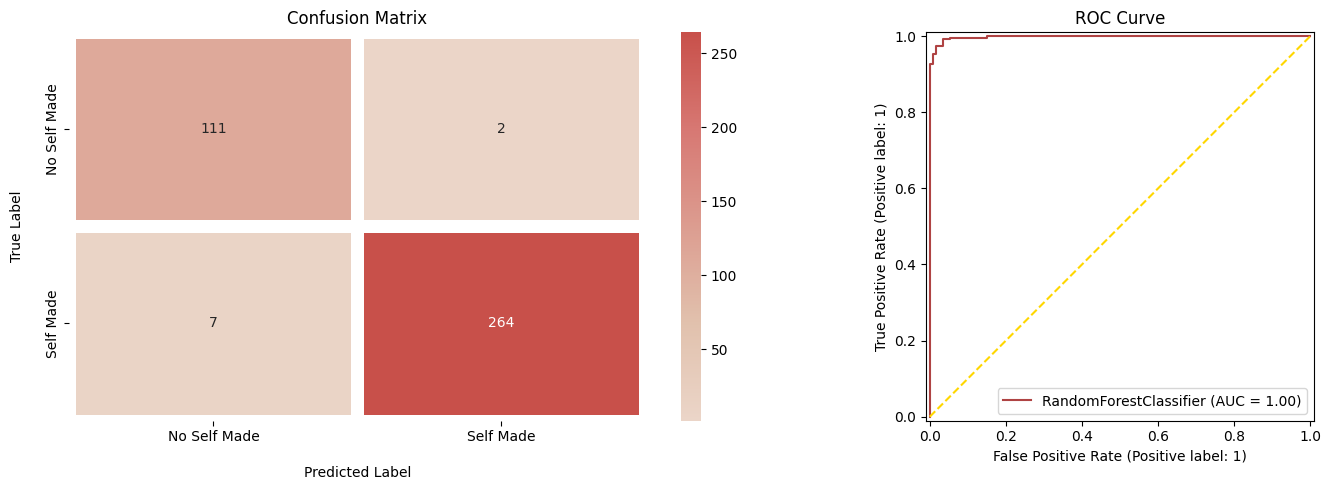

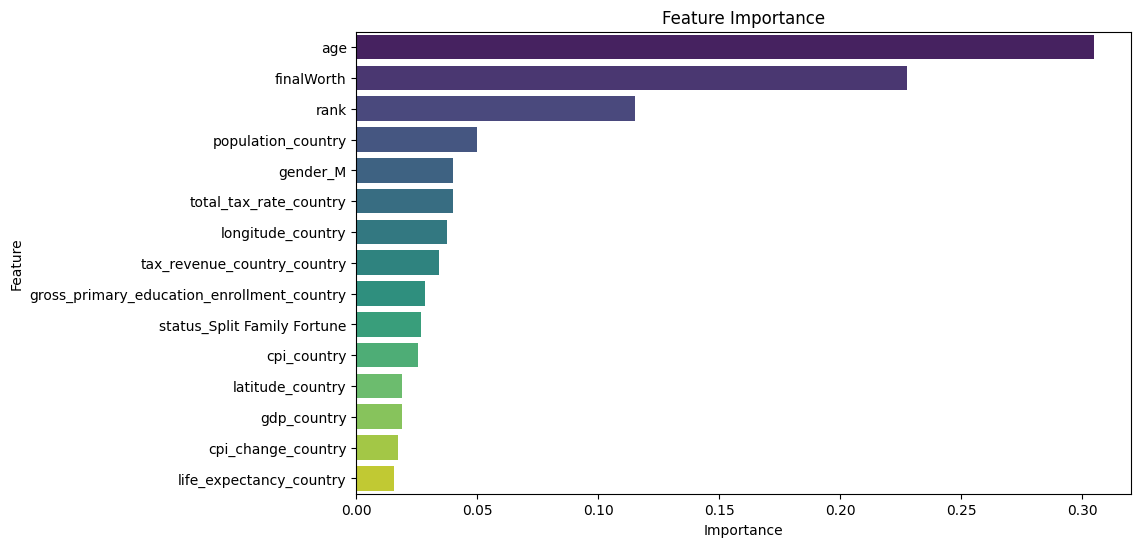

In [104]:


# ggnore all warnings
warnings.filterwarnings('ignore')

# drop the features
features_to_remove = ['gross_tertiary_education_enrollment', 'status_E', 'status_U', 'status_R', 'status_N']
X = X.drop(columns=features_to_remove)

# split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# define the parameter search space for RandomForestClassifier
param_space = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

# set the random seed for reproducibility
random_state = 25
np.random.seed(random_state)

# create the RandomForestClassifier model with balanced class weights
base_estimator = RandomForestClassifier(random_state=random_state, class_weight='balanced')

# apply SMOTE to the training data
smote = SMOTE(random_state=random_state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_val, y_train_val)

# perform Bayesian Optimization on the resampled data
bayes_search = BayesSearchCV(
    estimator=base_estimator,
    search_spaces=param_space,
    scoring='f1',
    cv=3,
    n_iter=50,
    random_state=random_state
)
bayes_search.fit(X_train_resampled, y_train_resampled)

# retrieve the best model and best parameters
best_model = bayes_search.best_estimator_
best_params = bayes_search.best_params_

# retrain the best model on the entire resampled training set
best_model.fit(X_train_resampled, y_train_resampled)

# evaluate the performance of the best model on the validation set using f1_score
y_val_pred = best_model.predict(X_val)
f1_val = f1_score(y_val, y_val_pred)

# evaluate the performance of the best model on the test set using f1_score
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
threshold = 0.4
y_test_pred_adjusted = (y_test_pred_proba > threshold).astype(int)
f1_test_adjusted = f1_score(y_test, y_test_pred_adjusted)

print('Best parameters found by Bagging with SMOTE:')
print(best_params)
print('F1-score on the validation set:', f1_val)
print('F1-score on the test set with adjusted threshold:', f1_test_adjusted)

# calculate the confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=[0, 1])

# define the class labels
classes = ['No Self Made', 'Self Made']

warm = LinearSegmentedColormap.from_list('warm',
                                         [(0, '#EBD5C8'),
                                          (0.25, '#E1C1AD'),
                                          (.75, '#D77873'),
                                          (1, '#C8504A')], N=256)

# create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='', cmap=warm, linecolor='white', linewidths=8, ax=ax[0])

# set labels and title for the confusion matrix plot
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('\nPredicted Label')
ax[0].set_ylabel('True Label\n')
ax[0].set_xticklabels(classes)
ax[0].set_yticklabels(classes)

# plot the ROC curve on the second subplot (assuming best_model is already defined)
RocCurveDisplay.from_estimator(best_model, X_val, y_val, ax=ax[1], color="#AF4343")
sns.lineplot(x=[0, 1], y=[0, 1], color='gold', linestyle="dashed", ax=ax[1])
ax[1].set_title('ROC Curve')

# adjust layout and show the plot
plt.tight_layout()
plt.show()

# extract the feature importance
feature_importance = best_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# sort the features
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


please ignore the folling cells, these are there for testing purposes only.

In [105]:
'''import warnings
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import RocCurveDisplay, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from skopt import BayesSearchCV

# Ignore all warnings
warnings.filterwarnings('ignore')

# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Define the parameter search space for RandomForestClassifier
param_space = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

# Set the random seed for reproducibility
random_state = 25
np.random.seed(random_state)

# Create the RandomForestClassifier model with balanced class weights
base_estimator = RandomForestClassifier(random_state=random_state, class_weight='balanced')

# Apply SMOTE to the training data
smote = SMOTE(random_state=random_state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_val, y_train_val)

# Perform Bayesian Optimization on the resampled data
bayes_search = BayesSearchCV(
    estimator=base_estimator,
    search_spaces=param_space,
    scoring='f1',
    cv=3,
    n_iter=50,
    random_state=random_state
)
bayes_search.fit(X_train_resampled, y_train_resampled)

# Retrieve the best model and best parameters
best_model = bayes_search.best_estimator_
best_params = bayes_search.best_params_

# Retrain the best model on the entire resampled training set
best_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the performance of the best model on the validation set using f1_score
y_val_pred = best_model.predict(X_val)
f1_val = f1_score(y_val, y_val_pred)

# Evaluate the performance of the best model on the test set using f1_score
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
threshold = 0.4  # Adjust this threshold value
y_test_pred_adjusted = (y_test_pred_proba > threshold).astype(int)
f1_test_adjusted = f1_score(y_test, y_test_pred_adjusted)

print('Best parameters found by Bagging with SMOTE:')
print(best_params)
print('F1-score on the validation set:', f1_val)
print('F1-score on the test set with adjusted threshold:', f1_test_adjusted)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_adjusted, labels=[0, 1])

# Define class labels
classes = ['No Self Made', 'Self Made']

warm = LinearSegmentedColormap.from_list('warm',
                                         [(0, '#EBD5C8'),
                                          (0.25, '#E1C1AD'),
                                          (.75, '#D77873'),
                                          (1, '#C8504A')], N=256)

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='', cmap=warm, linecolor='white', linewidths=8, ax=ax[0])

# Set labels and title for the confusion matrix plot
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('\nPredicted Label')
ax[0].set_ylabel('True Label\n')
ax[0].set_xticklabels(classes)
ax[0].set_yticklabels(classes)

# Plot the ROC curve on the second subplot (assuming best_model is already defined)
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax[1], color="#AF4343")
sns.lineplot(x=[0, 1], y=[0, 1], color='gold', linestyle="dashed", ax=ax[1])
ax[1].set_title('ROC Curve')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Feature-Importanz aus dem trainierten Modell extrahieren
feature_importance = best_model.feature_importances_

# Verknüpfen der Feature-Importanz mit den Feature-Namen
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sortieren der Features nach ihrer Bedeutung
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot der Feature-Importanz
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()'''



'import warnings\nfrom sklearn.ensemble import RandomForestClassifier, BaggingClassifier\nfrom sklearn.metrics import RocCurveDisplay, f1_score, confusion_matrix\nfrom sklearn.model_selection import train_test_split\nfrom imblearn.over_sampling import SMOTE\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom matplotlib.colors import LinearSegmentedColormap\nimport numpy as np\nfrom skopt import BayesSearchCV\n\n# Ignore all warnings\nwarnings.filterwarnings(\'ignore\')\n\n# Split data into train, validation, and test sets\nX_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\nX_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)\n\n# Define the parameter search space for RandomForestClassifier\nparam_space = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5],\n    \'min_samples_leaf\': [1, 2],\n    \'criterion\': [

In [106]:
'''import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ignore all warnings
warnings.filterwarnings('ignore')

# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Define the parameter search space for Bayesian Optimization
param_space = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

# Set the random seed for reproducibility
random_state = 25
np.random.seed(random_state)

# Create the RandomForestClassifier model with balanced class weights
rf_model = RandomForestClassifier(random_state=random_state, class_weight='balanced')

# Apply SMOTE to the training data
smote = SMOTE(random_state=random_state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_val, y_train_val)

# Perform Bayesian Optimization on the resampled data
bayes_search = BayesSearchCV(
    estimator=rf_model,
    search_spaces=param_space,
    scoring='f1',
    cv=3,
    n_iter=50,
    random_state=random_state
)
bayes_search.fit(X_train_resampled, y_train_resampled)

# Retrieve the best model and best parameters
best_model = bayes_search.best_estimator_
best_params = bayes_search.best_params_

# Retrain the best model on the entire resampled training set
best_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the performance of the best model on the validation set using f1_score
y_val_pred = best_model.predict(X_val)
f1_val = f1_score(y_val, y_val_pred)

# Evaluate the performance of the best model on the test set using f1_score
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
threshold = 0.4  # Adjust this threshold value
y_test_pred_adjusted = (y_test_pred_proba > threshold).astype(int)
f1_test_adjusted = f1_score(y_test, y_test_pred_adjusted)

print('Best parameters found by Bayesian Optimization with SMOTE:')
print(best_params)
print('F1-score on the validation set:', f1_val)
print('F1-score on the test set with adjusted threshold:', f1_test_adjusted)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_adjusted, labels=[0, 1])

# Define class labels
classes = ['No Self Made', 'Self Made']

warm = LinearSegmentedColormap.from_list('warm',
                                         [(0, '#EBD5C8'),
                                          (0.25, '#E1C1AD'),
                                          (.75, '#D77873'),
                                          (1, '#C8504A')], N=256)

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='', cmap=warm, linecolor='white', linewidths=8, ax=ax[0])

# Set labels and title for the confusion matrix plot
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('\nPredicted Label')
ax[0].set_ylabel('True Label\n')
ax[0].set_xticklabels(classes)
ax[0].set_yticklabels(classes)

# Plot the ROC curve on the second subplot (assuming best_model is already defined)
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax[1], color="#AF4343")
sns.lineplot(x=[0, 1], y=[0, 1], color='gold', linestyle="dashed", ax=ax[1])
ax[1].set_title('ROC Curve')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
'''

'import warnings\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import RocCurveDisplay, f1_score, confusion_matrix\nfrom sklearn.model_selection import train_test_split\nfrom skopt import BayesSearchCV\nfrom imblearn.over_sampling import SMOTE\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport numpy as np\n\n# Ignore all warnings\nwarnings.filterwarnings(\'ignore\')\n\n# Split data into train, validation, and test sets\nX_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\nX_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)\n\n# Define the parameter search space for Bayesian Optimization\nparam_space = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5],\n    \'min_samples_leaf\': [1, 2],\n    \'criterion\': [\'gini\', \'entropy\'],\n    \'class_weight\': [None, \'balanced\']\n}\n\n#

In [107]:
'''# Ignore all warnings
warnings.filterwarnings('ignore')

# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Define the parameter search space for Bayesian Optimization
param_space = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

# Set the random seed for reproducibility
random_state = 25
np.random.seed(random_state)

# Create the RandomForestClassifier model with balanced class weights
rf_model = RandomForestClassifier(random_state=random_state, class_weight='balanced')

# Perform Bayesian Optimization
bayes_search = BayesSearchCV(
    estimator=rf_model,
    search_spaces=param_space,
    scoring='f1',
    cv=3,
    n_iter=50,  # Number of parameter settings that are sampled
    random_state=random_state
)
bayes_search.fit(X_train_val, y_train_val)

# Retrieve the best model and best parameters
best_model = bayes_search.best_estimator_
best_params = bayes_search.best_params_

# Retrain the best model on the entire training set
best_model.fit(X_train_val, y_train_val)

# Evaluate the performance of the best model on the validation set using f1_score
y_val_pred = best_model.predict(X_val)
f1_val = f1_score(y_val, y_val_pred)

# Evaluate the performance of the best model on the test set using f1_score
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
threshold = 0.3  # Adjust this threshold value
y_test_pred_adjusted = (y_test_pred_proba > threshold).astype(int)
f1_test_adjusted = f1_score(y_test, y_test_pred_adjusted)

print('Best parameters found by Bayesian Optimization:')
print(best_params)
print('F1-score on the validation set:', f1_val)
print('F1-score on the test set with adjusted threshold:', f1_test_adjusted)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_adjusted, labels=[0, 1])

# Define class labels
classes = ['No Self Made', 'Self Made']

warm = LinearSegmentedColormap.from_list('warm',
                                         [(0, '#EBD5C8'),
                                          (0.25, '#E1C1AD'),
                                          (.75, '#D77873'),
                                          (1, '#C8504A')], N=256)

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='', cmap=warm, linecolor='white', linewidths=8, ax=ax[0])

# Set labels and title for the confusion matrix plot
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('\nPredicted Label')
ax[0].set_ylabel('True Label\n')
ax[0].set_xticklabels(classes)
ax[0].set_yticklabels(classes)

# Plot the ROC curve on the second subplot (assuming best_model is already defined)
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax[1], color="#AF4343")
sns.lineplot(x=[0, 1], y=[0, 1], color='gold', linestyle="dashed", ax=ax[1])
ax[1].set_title('ROC Curve')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()'''


'# Ignore all warnings\nwarnings.filterwarnings(\'ignore\')\n\n# Split data into train, validation, and test sets\nX_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\nX_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)\n\n# Define the parameter search space for Bayesian Optimization\nparam_space = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5],\n    \'min_samples_leaf\': [1, 2],\n    \'criterion\': [\'gini\', \'entropy\'],\n    \'class_weight\': [None, \'balanced\']\n}\n\n# Set the random seed for reproducibility\nrandom_state = 25\nnp.random.seed(random_state)\n\n# Create the RandomForestClassifier model with balanced class weights\nrf_model = RandomForestClassifier(random_state=random_state, class_weight=\'balanced\')\n\n# Perform Bayesian Optimization\nbayes_search = BayesSearchCV(\n    estimator=rf_model,\n    se

In [108]:
'''# Ignore all warnings
warnings.filterwarnings('ignore')

# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Define the parameter search space for Bayesian Optimization
param_space = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

# Set the random seed for reproducibility
random_state = 25
np.random.seed(random_state)

# Create the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=random_state)

# Perform Bayesian Optimization
bayes_search = BayesSearchCV(
    estimator=rf_model,
    search_spaces=param_space,
    scoring='f1',
    cv=3,
    n_iter=50,  # Number of parameter settings that are sampled
    random_state=random_state
)
bayes_search.fit(X_train_val, y_train_val)

# Retrieve the best model and best parameters
best_model = bayes_search.best_estimator_
best_params = bayes_search.best_params_

# Retrain the best model on the entire training set
best_model.fit(X_train_val, y_train_val)

# Evaluate the performance of the best model on the validation set using f1_score
y_val_pred = best_model.predict(X_val)
f1_val = f1_score(y_val, y_val_pred)

# Evaluate the performance of the best model on the test set using f1_score
y_test_pred = best_model.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)

print('Best parameters found by Bayesian Optimization:')
print(best_params)
print('F1-score on the validation set:', f1_val)
print('F1-score on the test set:', f1_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])

# Define class labels
classes = ['No Self Made', 'Self Made']

warm = LinearSegmentedColormap.from_list('warm',
                                         [(0, '#EBD5C8'),
                                          (0.25, '#E1C1AD'),
                                          (.75, '#D77873'),
                                          (1, '#C8504A')], N=256)

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='', cmap=warm, linecolor='white', linewidths=8, ax=ax[0])

# Set labels and title for the confusion matrix plot
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('\nPredicted Label')
ax[0].set_ylabel('True Label\n')
ax[0].set_xticklabels(classes)
ax[0].set_yticklabels(classes)

# Plot the ROC curve on the second subplot (assuming best_model is already defined)
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax[1], color="#AF4343")
sns.lineplot(x=[0, 1], y=[0, 1], color='gold', linestyle="dashed", ax=ax[1])
ax[1].set_title('ROC Curve')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()'''


'# Ignore all warnings\nwarnings.filterwarnings(\'ignore\')\n\n# Split data into train, validation, and test sets\nX_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\nX_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)\n\n# Define the parameter search space for Bayesian Optimization\nparam_space = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5],\n    \'min_samples_leaf\': [1, 2],\n    \'criterion\': [\'gini\', \'entropy\'],\n    \'class_weight\': [None, \'balanced\']\n}\n\n# Set the random seed for reproducibility\nrandom_state = 25\nnp.random.seed(random_state)\n\n# Create the RandomForestClassifier model\nrf_model = RandomForestClassifier(random_state=random_state)\n\n# Perform Bayesian Optimization\nbayes_search = BayesSearchCV(\n    estimator=rf_model,\n    search_spaces=param_space,\n    scoring=\'f1\',\n    cv=3

In [109]:
'''# Define a smaller hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

# Set the random seed for reproducibility
random_state = 25
np.random.seed(random_state)

# Create the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=random_state)

# Perform GridSearchCV with reduced parameters and folds
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Retrieve the best model and best parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Retrain the best model on the entire training set
best_model.fit(X_train, y_train)

# Evaluate the performance of the best model on the validation set using f1_score
y_val_pred = best_model.predict(X_val)
f1_val = f1_score(y_val, y_val_pred)

# Evaluate the performance of the best model on the test set using f1_score
y_test_pred = best_model.predict(X_test)
f1_test = f1_score(y_test_pred, y_test)

print('Best parameters found by GridSearchCV:')
print(best_params)
print('F1-score on the validation set:', f1_val)
print('F1-score on the test set:', f1_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])

# Define class labels
classes = ['No Self Made', 'Self Made']

warm=LinearSegmentedColormap.from_list('warm', 
                                       [(0, '#EBD5C8'), 
                                        (0.25, '#E1C1AD'),
                                        (.75, '#D77873'), 
                                        (1, '#C8504A')], N=256)

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='', cmap=warm, linecolor='white', linewidths=8, ax=ax[0])

# Set labels and title for the confusion matrix plot
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('\nPredicted Label')
ax[0].set_ylabel('True Label\n')
ax[0].set_xticklabels(classes)
ax[0].set_yticklabels(classes)

# Plot the ROC curve on the second subplot (assuming best_model is already defined)
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax[1], color="#AF4343")
sns.lineplot(x=[0, 1], y=[0, 1], color='gold', linestyle="dashed", ax=ax[1])
ax[1].set_title('ROC Curve')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()'''


'# Define a smaller hyperparameter grid\nparam_grid = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5],\n    \'min_samples_leaf\': [1, 2],\n    \'criterion\': [\'gini\', \'entropy\'],\n    \'class_weight\': [None, \'balanced\']\n}\n\n# Set the random seed for reproducibility\nrandom_state = 25\nnp.random.seed(random_state)\n\n# Create the RandomForestClassifier model\nrf_model = RandomForestClassifier(random_state=random_state)\n\n# Perform GridSearchCV with reduced parameters and folds\ngrid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3)\ngrid_search.fit(X_train, y_train)\n\n# Retrieve the best model and best parameters\nbest_model = grid_search.best_estimator_\nbest_params = grid_search.best_params_\n\n# Retrain the best model on the entire training set\nbest_model.fit(X_train, y_train)\n\n# Evaluate the performance of the best model on the validation set using f1_score\ny_val_pred = best_model

In [110]:
'''# Features und Zielvariable auswählen
X = df.drop(columns=['selfMade', 'rank', 'birthDate'])
y = pd.get_dummies(df['selfMade'].astype(int))  # One-Hot-Encoding für die Zielvariable

# One-Hot-Encoding für kategoriale Variablen durchführen
X_encoded = pd.get_dummies(X)

# Korrelationen der Merkmale mit der Zielvariable berechnen
corr = X_encoded.corrwith(y.iloc[:, 1])  # Wir verwenden nur eine der kategorialen Spalten aus y

# Nur die Top 20 korrelierten Features auswählen
top_corr_features = corr.abs().sort_values(ascending=False).head(20)
corr = corr[top_corr_features.index]

# Plot für die Feature-Korrelationen mit der Zielvariable (nur Top 20)
plt.figure(figsize=(10, 8))
colors = ['red' if c < 0 else 'blue' for c in corr]
plt.barh(corr.index, corr, color=colors)
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.title('Top 20 Feature Correlations with Target')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Features für das RFE-Verfahren auswählen
features_for_rfe = X_encoded.columns

# Random Forest Classifier initialisieren und trainieren
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_encoded, y.iloc[:, 1])  # Wir verwenden nur eine der kategorialen Spalten aus y

# RFE durchführen
rfe = RFE(estimator=rf_classifier, n_features_to_select=10)
rfe.fit(X_encoded, y.iloc[:, 1])  # Wir verwenden nur eine der kategorialen Spalten aus y

# Ausgewählte Merkmale anzeigen
selected_features_rfe = features_for_rfe[rfe.support_]
print("Relevante Merkmale nach RFE:")
print(selected_features_rfe)

# Datensatz mit ausgewählten Features aktualisieren
X_selected = X_encoded[selected_features_rfe]

# Datensatz in Trainings- und Testdatensätze aufteilen
X_train, X_test, y_train, y_test = train_test_split(X_selected, y.iloc[:, 1], test_size=0.3, random_state=42)

# Random Forest Classifier mit ausgewählten Features trainieren
rf_classifier_selected = RandomForestClassifier(random_state=42)
rf_classifier_selected.fit(X_train, y_train)

# Vorhersagen für Testdaten machen
y_pred = rf_classifier_selected.predict(X_test)

# F1-Score berechnen
f1_rfe = f1_score(y_test, y_pred)
print(f'F1-Score (using RFE feature selection): {f1_rfe}')

# F1-Score für korrelationsbasierte Featureauswahl berechnen
X_corr_selected = X_encoded[top_corr_features.index]
X_train_corr, X_test_corr, _, _ = train_test_split(X_corr_selected, y.iloc[:, 1], test_size=0.3, random_state=42)
rf_classifier_corr = RandomForestClassifier(random_state=42)
rf_classifier_corr.fit(X_train_corr, y_train)
y_pred_corr = rf_classifier_corr.predict(X_test_corr)
f1_corr = f1_score(y_test, y_pred_corr)
print(f'F1-Score (using correlation-based feature selection): {f1_corr}')

# Dummy-Modell als Basislinie trainieren und evaluieren
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)
dummy_pred = dummy_classifier.predict(X_test)
dummy_f1 = f1_score(y_test, dummy_pred)
print(f'Dummy F1-Score (using RFE feature selection): {dummy_f1}')'''


'# Features und Zielvariable auswählen\nX = df.drop(columns=[\'selfMade\', \'rank\', \'birthDate\'])\ny = pd.get_dummies(df[\'selfMade\'].astype(int))  # One-Hot-Encoding für die Zielvariable\n\n# One-Hot-Encoding für kategoriale Variablen durchführen\nX_encoded = pd.get_dummies(X)\n\n# Korrelationen der Merkmale mit der Zielvariable berechnen\ncorr = X_encoded.corrwith(y.iloc[:, 1])  # Wir verwenden nur eine der kategorialen Spalten aus y\n\n# Nur die Top 20 korrelierten Features auswählen\ntop_corr_features = corr.abs().sort_values(ascending=False).head(20)\ncorr = corr[top_corr_features.index]\n\n# Plot für die Feature-Korrelationen mit der Zielvariable (nur Top 20)\nplt.figure(figsize=(10, 8))\ncolors = [\'red\' if c < 0 else \'blue\' for c in corr]\nplt.barh(corr.index, corr, color=colors)\nplt.xlabel(\'Correlation\')\nplt.ylabel(\'Features\')\nplt.title(\'Top 20 Feature Correlations with Target\')\nplt.grid(axis=\'x\', linestyle=\'--\', alpha=0.7)\nplt.show()\n\n# Features für da

In [111]:
'''from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Identify columns with categorical data
categorical_columns = X_selected.select_dtypes(include=['object']).columns

# Relevant features after RFE
relevant_features = ['finalWorth', 'age', 'birthYear', 'birthMonth', 'birthDay',
                     'tax_revenue_country_country', 'total_tax_rate_country',
                     'population_country', 'longitude_country', 'gender']

# Subset the data to include only the relevant features
X_train_selected = X_train[relevant_features]
X_test_selected = X_test[relevant_features]

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), categorical_columns)],
    remainder='passthrough'
)

# Transform data
X_train_encoded = preprocessor.fit_transform(X_train_selected)
X_test_encoded = preprocessor.transform(X_test_selected)

# Initialize and train the XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_encoded, y_train)

# Make predictions on test data
y_pred = xgb_classifier.predict(X_test_encoded)

# Evaluation of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"])

# Show results
print(f'Accuracy XGBoost: {accuracy:.4f}\n')
print('\nClassification report:')
print(classification_rep)

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()'''


'from sklearn.compose import ColumnTransformer\nfrom sklearn.preprocessing import OneHotEncoder\nfrom xgboost import XGBClassifier\nfrom sklearn.metrics import accuracy_score, classification_report, confusion_matrix\nfrom sklearn.feature_selection import SelectKBest, mutual_info_classif\n\n# Identify columns with categorical data\ncategorical_columns = X_selected.select_dtypes(include=[\'object\']).columns\n\n# Relevant features after RFE\nrelevant_features = [\'finalWorth\', \'age\', \'birthYear\', \'birthMonth\', \'birthDay\',\n                     \'tax_revenue_country_country\', \'total_tax_rate_country\',\n                     \'population_country\', \'longitude_country\', \'gender\']\n\n# Subset the data to include only the relevant features\nX_train_selected = X_train[relevant_features]\nX_test_selected = X_test[relevant_features]\n\n# Create column transformer\npreprocessor = ColumnTransformer(\n    transformers=[(\'encoder\', OneHotEncoder(), categorical_columns)],\n    remain

In [112]:
'''from random import uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definieren Sie den Hyperparameterraum
param_dist = {
    'n_estimators': randint(50, 200),
    'max_features': ['auto', 'sqrt', 'log2', None, randint(1, n_features), uniform(0.01, 1.0)],
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}



# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialisieren Sie RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, 
                                   n_iter=100, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)

# Führen Sie die Suche durch
random_search.fit(X_train_encoded, y_train)

# Beste Hyperparameter
best_params = random_search.best_params_
print("Beste Hyperparameter:")
print(best_params)

# Vorhersagen auf Testdaten machen
y_pred = random_search.predict(X_test_encoded)

# Evaluierung des Modells auf den Testdaten
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"])

# Ergebnisse anzeigen
print(f'Accuracy Random Forest nach RandomizedSearchCV: {accuracy:.4f}\n')
print('\nClassification report:')
print(classification_rep)

# Compute und plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()'''


'from random import uniform\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import randint\n\n# Definieren Sie den Hyperparameterraum\nparam_dist = {\n    \'n_estimators\': randint(50, 200),\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\', None, randint(1, n_features), uniform(0.01, 1.0)],\n    \'max_depth\': randint(10, 100),\n    \'min_samples_split\': randint(2, 20),\n    \'min_samples_leaf\': randint(1, 20),\n    \'bootstrap\': [True, False]\n}\n\n\n\n# Initialize Random Forest Classifier\nrf_classifier = RandomForestClassifier(random_state=42)\n\n# Initialisieren Sie RandomizedSearchCV\nrandom_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, \n                                   n_iter=100, cv=3, scoring=\'accuracy\', random_state=42, n_jobs=-1)\n\n# Führen Sie die Suche durch\nrandom_search.fit(X_train_encoded, y_train)\n\n# Beste Hyperparameter\nbest_params = random_search.best_params_\nprint("Beste Hyperparameter

In [113]:
'''from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to the data
grid_search.fit(X_train_encoded, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Make predictions on test data using the best model
best_rf_classifier = grid_search.best_estimator_
y_pred = best_rf_classifier.predict(X_test_encoded)

# Evaluation of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"])

# Show results
print(f'\nAccuracy Random-Forest after GridSearchCV: {accuracy:.4f}\n')
print('\nClassification report:')
print(classification_rep)

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix after GridSearchCV')
plt.show()
'''

'from sklearn.model_selection import GridSearchCV\n\n# Define parameter grid for Random Forest\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [None, 10, 20],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4]\n}\n\n# Initialize Random Forest classifier\nrf_classifier = RandomForestClassifier(random_state=42)\n\n# Initialize GridSearchCV\ngrid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring=\'accuracy\', n_jobs=-1)\n\n# Fit the GridSearchCV to the data\ngrid_search.fit(X_train_encoded, y_train)\n\n# Get the best parameters\nbest_params = grid_search.best_params_\nprint("Best Parameters:", best_params)\n\n# Make predictions on test data using the best model\nbest_rf_classifier = grid_search.best_estimator_\ny_pred = best_rf_classifier.predict(X_test_encoded)\n\n# Evaluation of the model on the test data\naccuracy = accuracy_score(y_test, y_pred)\nclassification_rep = classification_report(y_test, y